In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/polar-lows-detection-forecasting-deep-learning/
    !pip install pytorch-lightning
    !pip install captum
    !pip install timm

In [1]:
import os

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

from config import (
    train_dir,
    test_dir,
    num_workers,
    resized_image_res,
    verbose,
    device
)
from data_loader import create_data_loaders, get_transforms
from model_container import ModelContainer
from models import XceptionModel
import gradcam

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache() # Empty CUDA cache

In [3]:
batch_size = 32
_, val_loader, _ = create_data_loaders(train_dir, test_dir, resized_image_res, batch_size, num_workers, verbose=verbose)

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
model = XceptionModel(num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Load model
lit_model = ModelContainer.load_from_checkpoint('checkpoints/xception-oct-13.ckpt', model=model, criterion=criterion, optimizer=optimizer)

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating model'):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

In [7]:
val_preds, val_labels = evaluate_model(lit_model, val_loader, device)

cm = confusion_matrix(val_labels, val_preds)
print("\n\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['neg', 'pos']))

f1 = f1_score(val_labels, val_preds, pos_label=1)
precision = precision_score(val_labels, val_preds, pos_label=1)
recall = recall_score(val_labels, val_preds, pos_label=1)

print(f"\nF1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# Data prep transformations
_, data_prep = get_transforms(resized_image_res)

Selected pointwise convolution layer: body.conv4.pointwise - Conv2d(1536, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


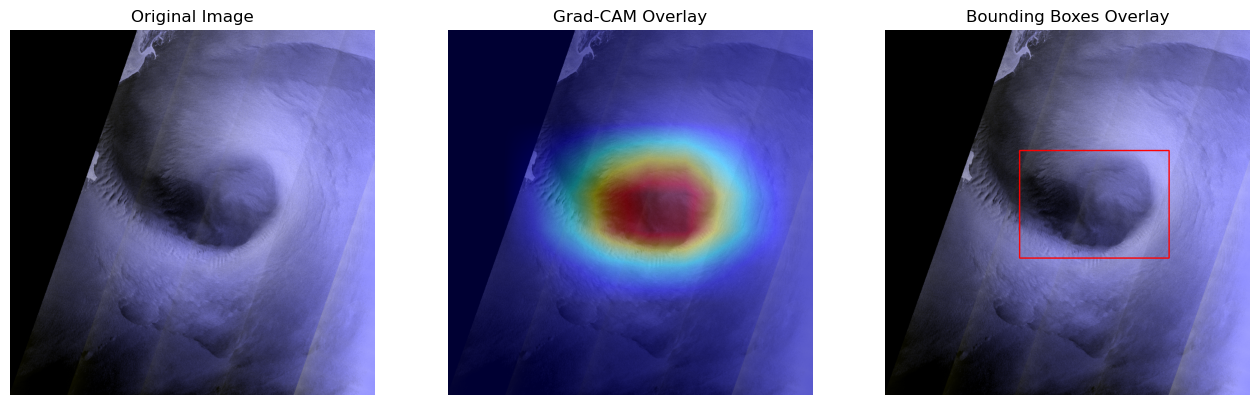

Image path: data/train/pos/634bbf_20150110T073827_20150110T074044_mos_rgb.png
Predicted: pos. Actual: pos


In [14]:
pos_images = os.listdir(os.path.join(train_dir, 'pos')) # Directory of 'pos' images
neg_images = os.listdir(os.path.join(train_dir, 'neg')) # Directory of 'neg' images

# Pick random image
category = random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir, category)))
image_path = os.path.join(train_dir, category, chosen_image)

# image_path = 'data/train/neg/738a7a_20170824T062455_20170824T062608_mos_rgb.png'

# Prepare image
original_image = Image.open(image_path).convert('RGB')
transformed_image = data_prep(original_image).unsqueeze(0)


gc = gradcam.GradCAM(model, device)
# Create and overlay GradCAM heatmap
gradcam_heatmap = gc.generate_gradcam_heatmap(transformed_image)
gradcam_overlayed = gc.overlay_heatmap(original_image, gradcam_heatmap)
bb_overlayed = gc.generate_and_overlay_bounding_boxes(original_image, gradcam_heatmap)

# Create and overlay Integrated Gradients heatmap
# ig_heatmap, predicted_class = lit_model.generate_integrated_gradients_heatmap(transformed_image)
# ig_overlayed = lit_model.overlay_green_heatmap(original_image, ig_heatmap, predicted_class)


# Display image with and without heatmap

plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1) # plt.subplot(num_rows, num_columns, index)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Image with Grad-CAM heatmap
plt.subplot(1, 3, 2)
plt.imshow(gradcam_overlayed)
plt.title('Grad-CAM Overlay')
plt.axis('off')

# GradCAM heatmap
# plt.subplot(1, 3, 3)
# plt.imshow(gradcam_heatmap)
# plt.title('Grad-CAM Heatmap')
# plt.axis('off')

# Image with bounding boxes
plt.subplot(1, 3, 3)
plt.imshow(bb_overlayed)
plt.title('Bounding Boxes Overlay')
plt.axis('off')

# Image with Integrated Gradients heatmap
# plt.subplot(1, 3, 3)
# plt.imshow(ig_overlayed)
# plt.title('Integrated Gradients Overlay')
# plt.axis('off')

plt.show()


# Print additional info

print(f'Image path: {image_path}') # Print image path

pred = torch.argmax(lit_model(transformed_image.to(device)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: {category}')

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


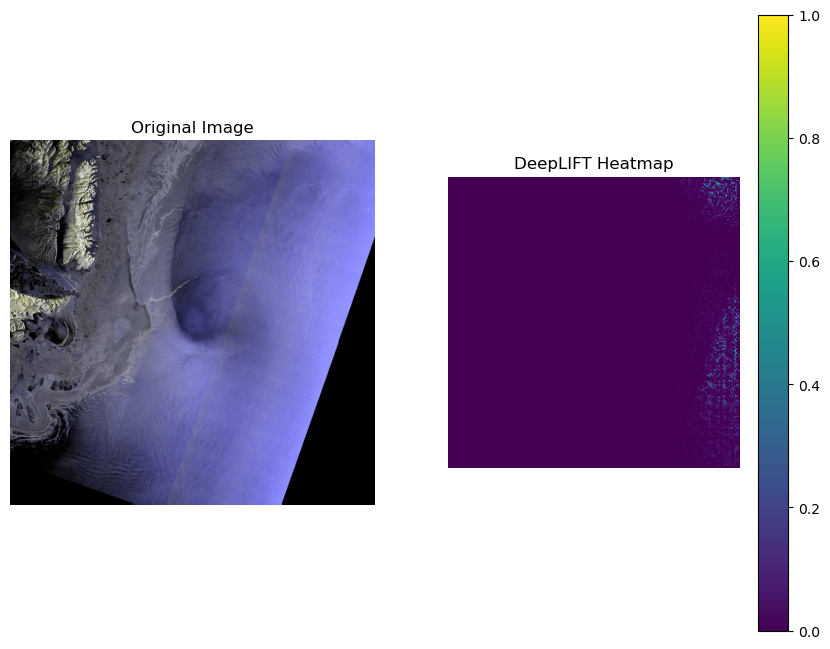

Image path: data/train/pos/93ff11_20180208T080245_20180208T080445_mos_rgb.png


In [9]:
pos_images = os.listdir(os.path.join(train_dir, 'pos')) # Directory of 'pos' images
neg_images = os.listdir(os.path.join(train_dir, 'neg')) # Directory of 'neg' images

# Pick random image
category = random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir, category)))
image_path = os.path.join(train_dir, category, chosen_image)

# image_path = 'data/train/pos/ac2464_20161130T110210_20161130T110410_mos_rgb.png'

# Prepare image
original_image = Image.open(image_path).convert('RGB')
transformed_image = data_prep(original_image).unsqueeze(0)

baseline = torch.full_like(transformed_image, fill_value=0.5).to(device)
deeplift_heatmap = lit_model.generate_deeplift_heatmap(transformed_image)


# Display image with and without heatmap

plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1) # plt.subplot(num_rows, num_columns, index)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# DeepLIFT heatmap
plt.subplot(1, 3, 2)
plt.imshow(deeplift_heatmap)
plt.colorbar()
plt.title('DeepLIFT Heatmap')
plt.axis('off')

plt.show()

# Print additional info

print(f'Image path: {image_path}') # Print image path

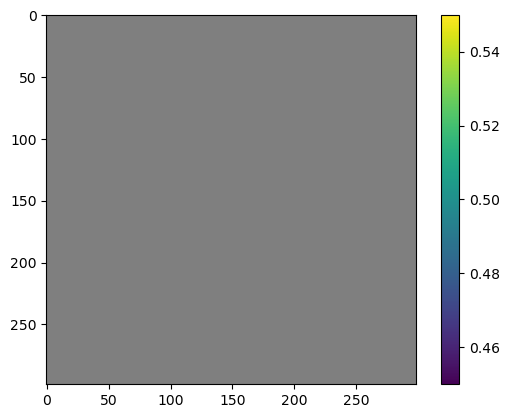

In [10]:
plt.imshow(baseline.to('cpu').squeeze(0).permute(1, 2, 0))
plt.colorbar()
plt.show()

In [11]:
baseline

tensor([[[[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0